# **Bitcoin Time Series Momentum Trading**

In [104]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from hmmlearn.hmm import GaussianHMM
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew, kurtosis

In [39]:
bitcoin_1min = pl.read_csv("btcusd_1-min_data.csv")

bitcoin_1min = bitcoin_1min.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
).rename({"Timestamp": "Date"})

print(bitcoin_1min)

shape: (6_729_281, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Date                ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ 2012-01-01 10:01:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:02:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:03:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:04:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:05:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ …                   ┆ …        ┆ …        ┆ …        ┆ …        ┆ …         │
│ 2024-12-15 23:57:00 ┆ 104510.0 ┆ 104510.0 ┆ 104257.0 ┆ 104268.0 ┆ 27.923539 │
│ 2024-12-15 23:58

In [40]:
print(bitcoin_1min.null_count())

shape: (1, 8)
┌──────┬──────┬──────┬─────┬───────┬────────┬─────────────┬────────────────────┐
│ Date ┆ Open ┆ High ┆ Low ┆ Close ┆ Volume ┆ log_returns ┆ hourly_log_returns │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    ┆ ---         ┆ ---                │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32    ┆ u32         ┆ u32                │
╞══════╪══════╪══════╪═════╪═══════╪════════╪═════════════╪════════════════════╡
│ 0    ┆ 0    ┆ 0    ┆ 0   ┆ 0     ┆ 0      ┆ 0           ┆ 0                  │
└──────┴──────┴──────┴─────┴───────┴────────┴─────────────┴────────────────────┘


In [41]:
bitcoin_1min = bitcoin_1min.filter(
    pl.col("Date").is_not_null()
)

## **Exploratory Data Analysis**

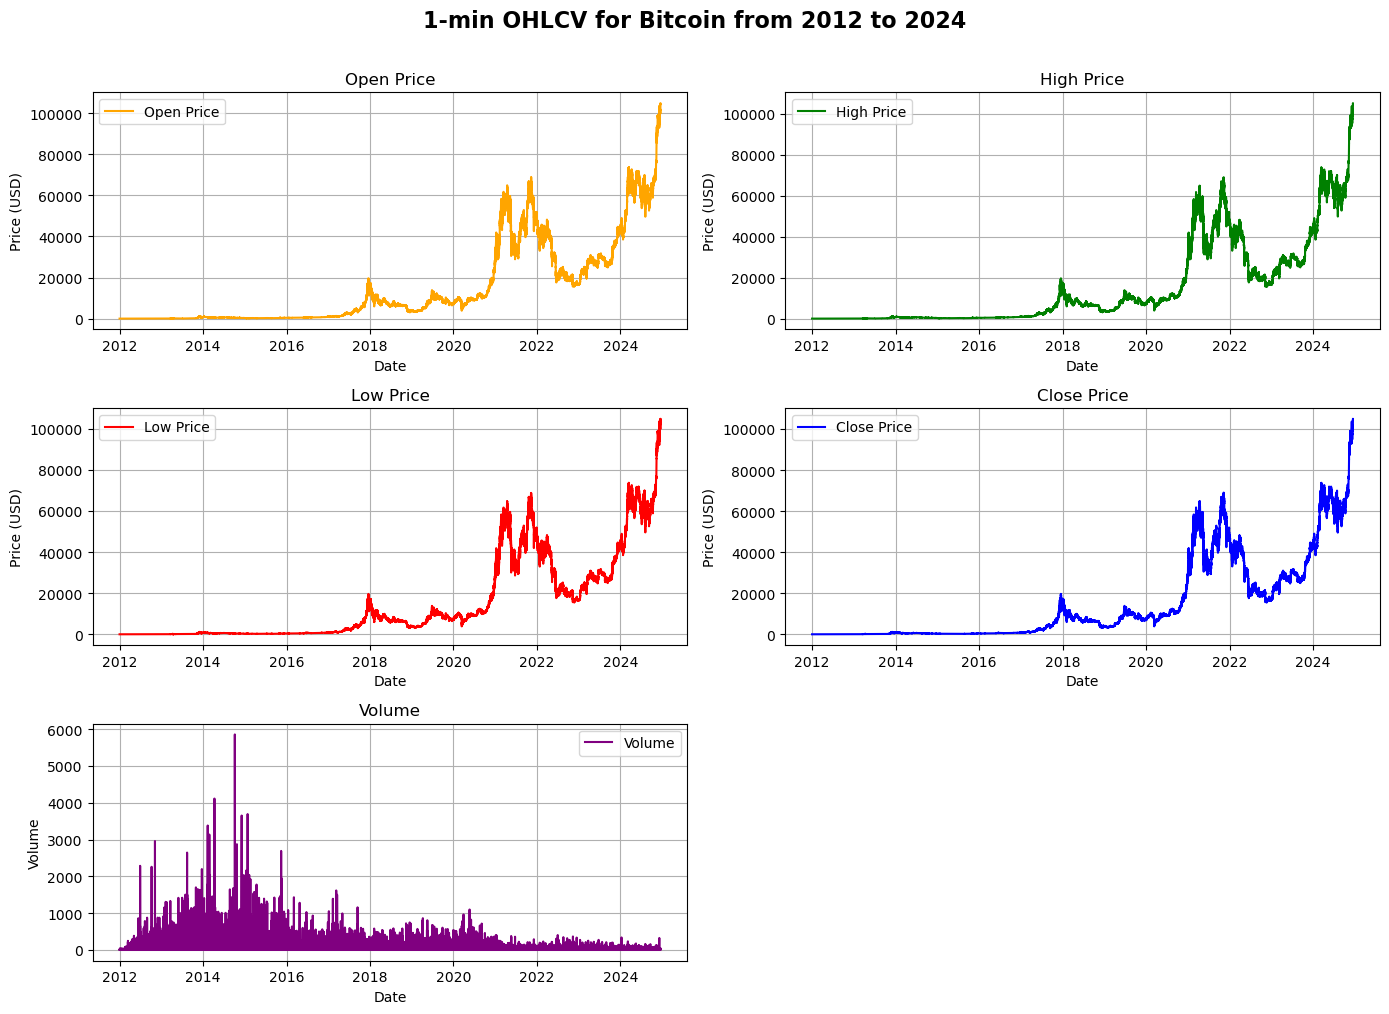

In [42]:
def plot_ohlcv(prices):
    """
    Plots Open, High, Low, Close and Volume prices in a 3x2 grid.

    Args:
        bitcoin (pl.DataFrame): Polars DataFrame containing OHLC and Volume data.
    """
    ohlcv_configs = [
        ("Open", "orange", "Open Price"),
        ("High", "green", "High Price"),
        ("Low", "red", "Low Price"),
        ("Close", "blue", "Close Price"),
        ("Volume", "purple", "Volume")
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    plt.suptitle("1-min OHLCV for Bitcoin from 2012 to 2024", fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (col_name, color, title) in zip(axes, ohlcv_configs):
        ax.plot(prices["Date"], prices[col_name], color=color, label=title)
        ax.set_title(title)
        ax.set_ylabel(f"Price (USD)" if col_name != "Volume" else "Volume")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True)

    for ax in axes[len(ohlcv_configs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_ohlcv(bitcoin_1min)

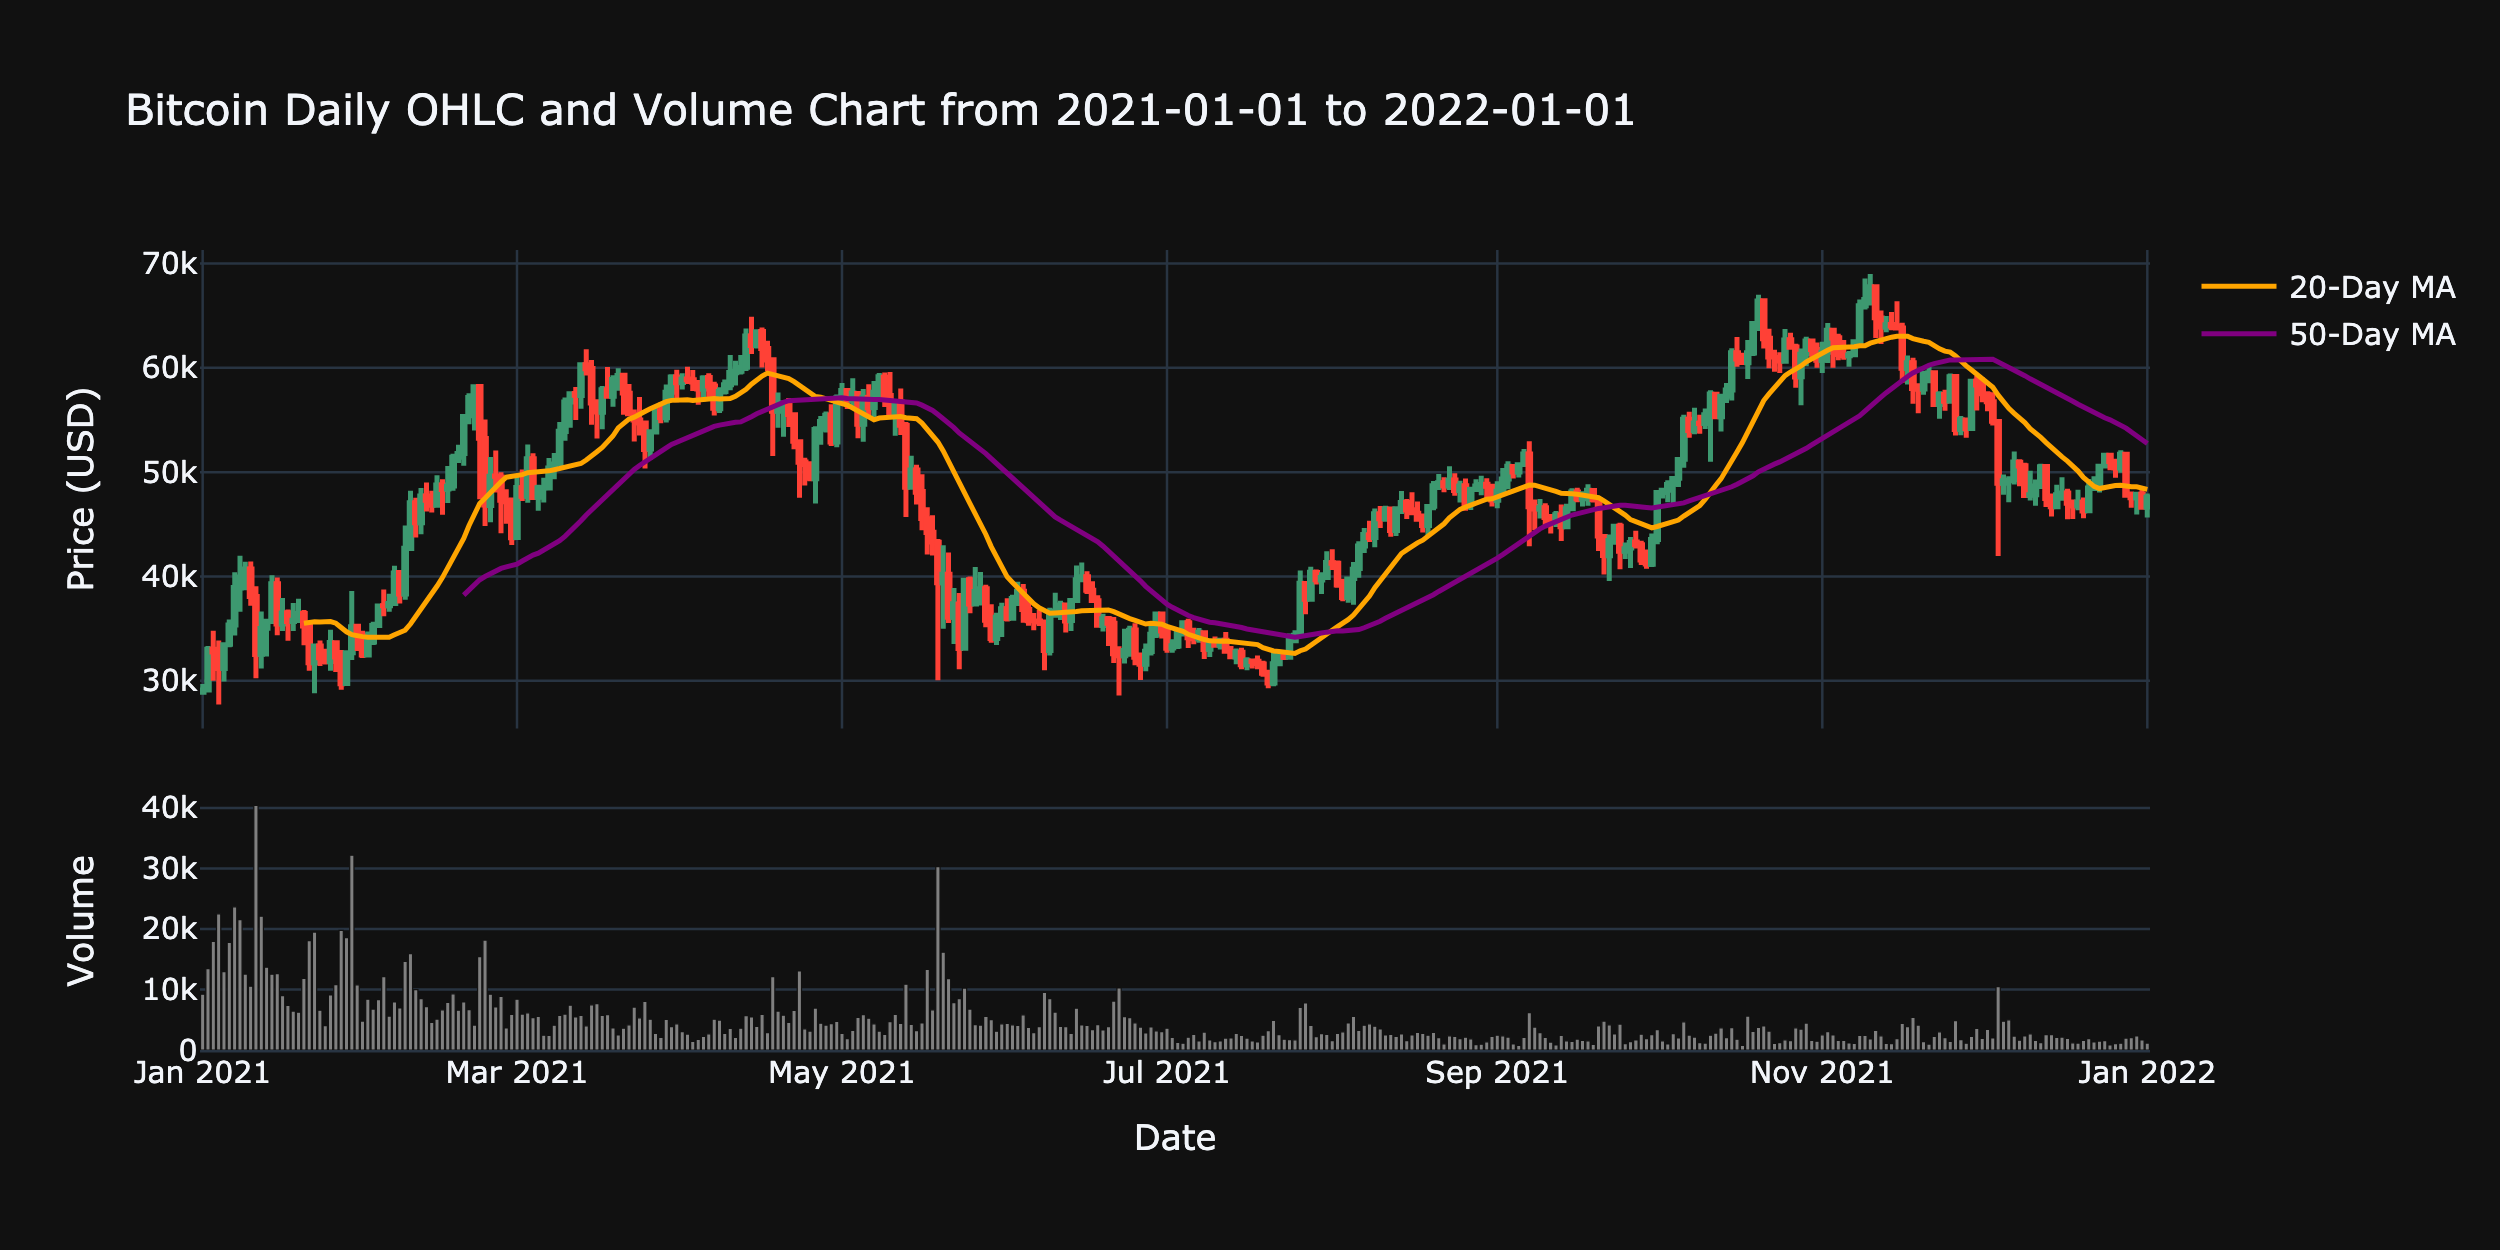

In [136]:
from IPython.display import Image
def plot_daily_candlesticks(prices, start, end=None):
    prices_daily = prices.group_by(
        pl.col("Date").dt.date().alias("Day")
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Day")

    if end:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start,
            pl.col("Day") <= end
        )
    else:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start
        )

    prices_daily = prices_daily.with_columns(
        pl.col("Close").rolling_mean(window_size=20).alias("MA_20"),
        pl.col("Close").rolling_mean(window_size=50).alias("MA_50")
    )

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, 
        row_heights=[0.65, 0.35],  
        vertical_spacing=0.08, 
    )

    fig.add_trace(
        go.Candlestick(
            x=prices_daily.select('Day').to_series(),
            open=prices_daily.select('Open').to_series(),
            high=prices_daily.select('High').to_series(),
            low=prices_daily.select('Low').to_series(),
            close=prices_daily.select('Close').to_series(),
            showlegend=False
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_20').to_series(),
            line=dict(color='orange', width=2),
            name="20-Day MA"
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_50').to_series(),
            line=dict(color='purple', width=2),
            name="50-Day MA"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('Volume').to_series(),
            marker_color="gray",
            showlegend=False
        ),
        row=2, col=1
    )

    min_date = prices_daily["Day"].min()
    max_date = prices_daily["Day"].max()
    fig.update_layout(
        title_text=f"Bitcoin Daily OHLC and Volume Chart from {min_date} to {max_date}",
        yaxis_title="Price (USD)",
        xaxis2_title="Date",
        yaxis2_title="Volume",
        template="plotly_dark",
        width=1000, height=600,
        xaxis_rangeslider_visible=False,
        showlegend=True,
    )
    fig.write_image("plots/candlesticks.png", scale=2.5, width=1000, height=500)

plot_daily_candlesticks(bitcoin_1min, datetime(2021, 1,1), datetime(2022, 1, 1))
Image("plots/candlesticks.png")

### **Resampling**

In [73]:
def resample_ohlcv(prices, interval):
    """
    Resample OHLCV data to a specified interval.

    Args:
        prices (pl.DataFrame): The Polars DataFrame containing OHLCV data.
        interval (str): The resampling interval (e.g., '5m', '10m', '15m').

    Returns:
        pl.DataFrame: Resampled OHLCV DataFrame.
    """
    return prices.group_by(
        pl.col("Date").dt.truncate(interval)
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Date")

intervals = ["5m", "10m", "15m"]
resampled_bitcoin = {"bitcoin_1m": bitcoin_1min}

for interval in intervals:
    resampled_bitcoin[f"bitcoin_{interval}"] = resample_ohlcv(bitcoin_1min, interval)

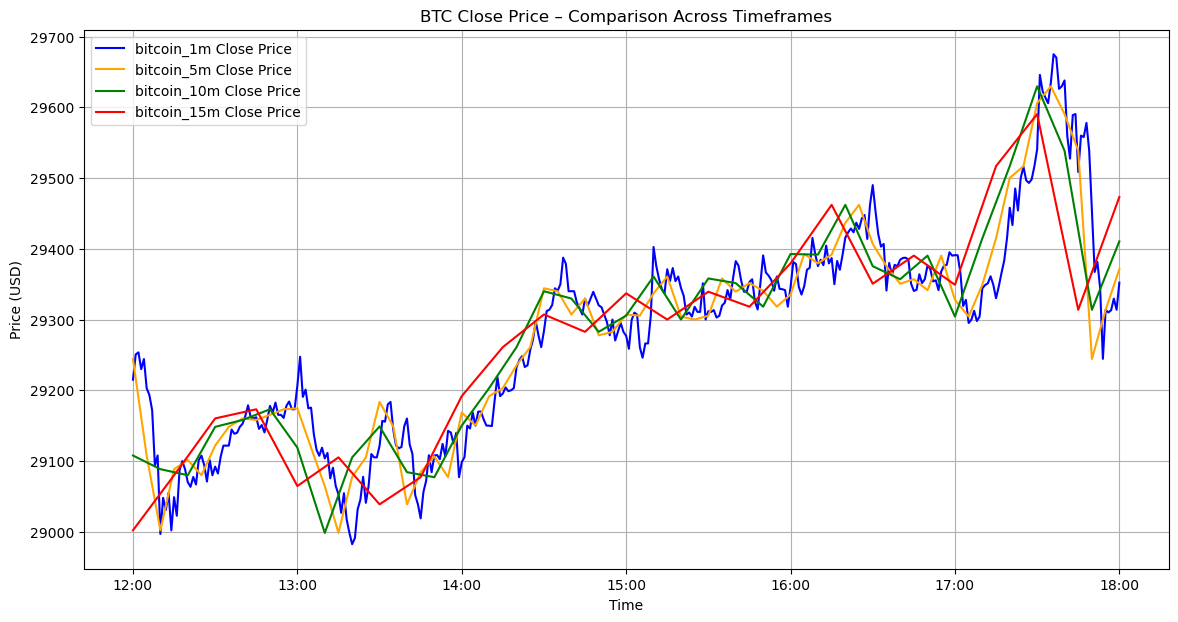

In [83]:
COLOR_MAP = {
    "bitcoin_1m": "blue",
    "bitcoin_5m": "orange",
    "bitcoin_10m": "green",
    "bitcoin_15m": "red"
}

def plot_resampled(resampled_data, start, end):
    """
    Plot BTC price data across multiple timeframes to visualize smoothing trends.
    
    Args:
        resampled_data (dict): Dictionary of resampled Polars DataFrames (5min, 10min, etc.).
        start (datetime): Start datetime for the plot.
        end (datetime): End datetime for the plot.
    """
    plt.figure(figsize=(14, 7))

    for interval, df in resampled_data.items():
        subset = df.filter(
            (pl.col("Date") >= start) & (pl.col("Date") <= end)
        ).select("Date", "Close")
        
        plt.plot(
            subset.select("Date"), subset.select("Close"), 
            color=COLOR_MAP.get(interval, "blue"),
            label=f"{interval} Close Price",
        )

    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.title("BTC Close Price – Comparison Across Timeframes")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

start = datetime(2021, 1, 1, 12)
end = start + timedelta(hours=6)
plot_resampled(resampled_bitcoin, start=start, end=end)

### **Log Returns**

In [ ]:
def calculate_log_returns(prices, col_name="Close"):
    """
    Calculate log returns for a given price column in a Polars DataFrame.

    Args:
        prices (pl.DataFrame): Polars DataFrame containing OHLC data.
        col_name (str): The column to compute log returns from (default is 'Close').

    Returns:
        pl.DataFrame: DataFrame with an additional 'log_returns' column.
    """
    return prices.with_columns(
        (pl.col(col_name) / pl.col(col_name).shift(1)).log().alias("log_returns")
    ).filter(
        pl.col("log_returns").is_not_null()
    )

# Compute log returns
for interval, df in resampled_bitcoin.items():
    resampled_bitcoin[interval] = calculate_log_returns(df)

# Compute descriptive statistics of log returns
desc_stats = []
statistic_column = None

for interval, df in resampled_bitcoin.items():
    desc = df.select("log_returns").describe()
    
    if statistic_column is None:
        statistic_column = desc.select("statistic")
    desc = desc.select("log_returns").rename({"log_returns": f"{interval} Log Returns"})
    desc_stats.append(desc)

combined_desc = pl.concat([statistic_column] + desc_stats, how="horizontal")
print(combined_desc)

shape: (9, 5)
┌────────────┬────────────────┬────────────────┬─────────────────────────┬─────────────────────────┐
│ statistic  ┆ bitcoin_1m Log ┆ bitcoin_5m Log ┆ bitcoin_10m Log Returns ┆ bitcoin_15m Log Returns │
│ ---        ┆ Returns        ┆ Returns        ┆ ---                     ┆ ---                     │
│ str        ┆ ---            ┆ ---            ┆ f64                     ┆ f64                     │
│            ┆ f64            ┆ f64            ┆                         ┆                         │
╞════════════╪════════════════╪════════════════╪═════════════════════════╪═════════════════════════╡
│ count      ┆ 6.729278e6     ┆ 1.345901e6     ┆ 672973.0                ┆ 448678.0                │
│ null_count ┆ 0.0            ┆ 0.0            ┆ 0.0                     ┆ 0.0                     │
│ mean       ┆ 0.000001       ┆ 0.000007       ┆ 0.000015                ┆ 0.000022                │
│ std        ┆ 0.001853       ┆ 0.003558       ┆ 0.004821                ┆ 0.

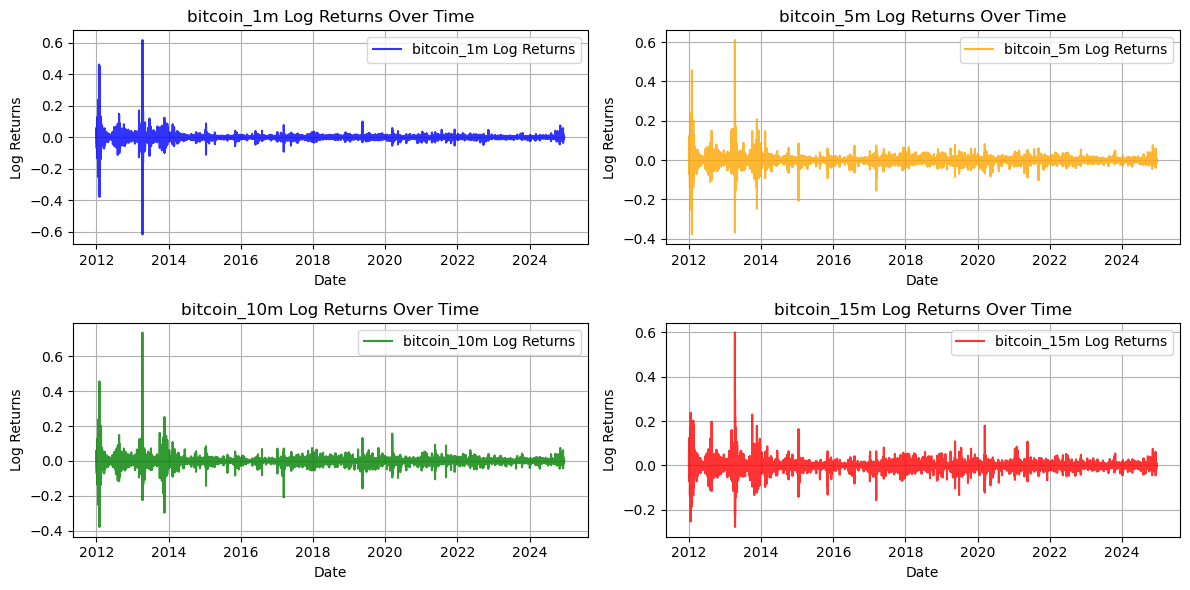

In [93]:
def plot_log_returns_resampled(resampled_data, start=None, end=None):
    """
    Plot log returns as line plots for different timeframes in a 2x2 grid.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()

    for ax, (interval, data) in zip(axes, resampled_data.items()):
        # Filter data if start and end are provided
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        ax.plot(
            data.select("Date"), data.select("log_returns"), 
            label=f"{interval} Log Returns", color=COLOR_MAP.get(interval, "blue"), alpha=0.8
        )
        
        ax.set_title(f"{interval} Log Returns Over Time")
        ax.set_xlabel("Date")
        ax.set_ylabel("Log Returns")
        ax.legend()
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_log_returns_resampled(resampled_bitcoin)

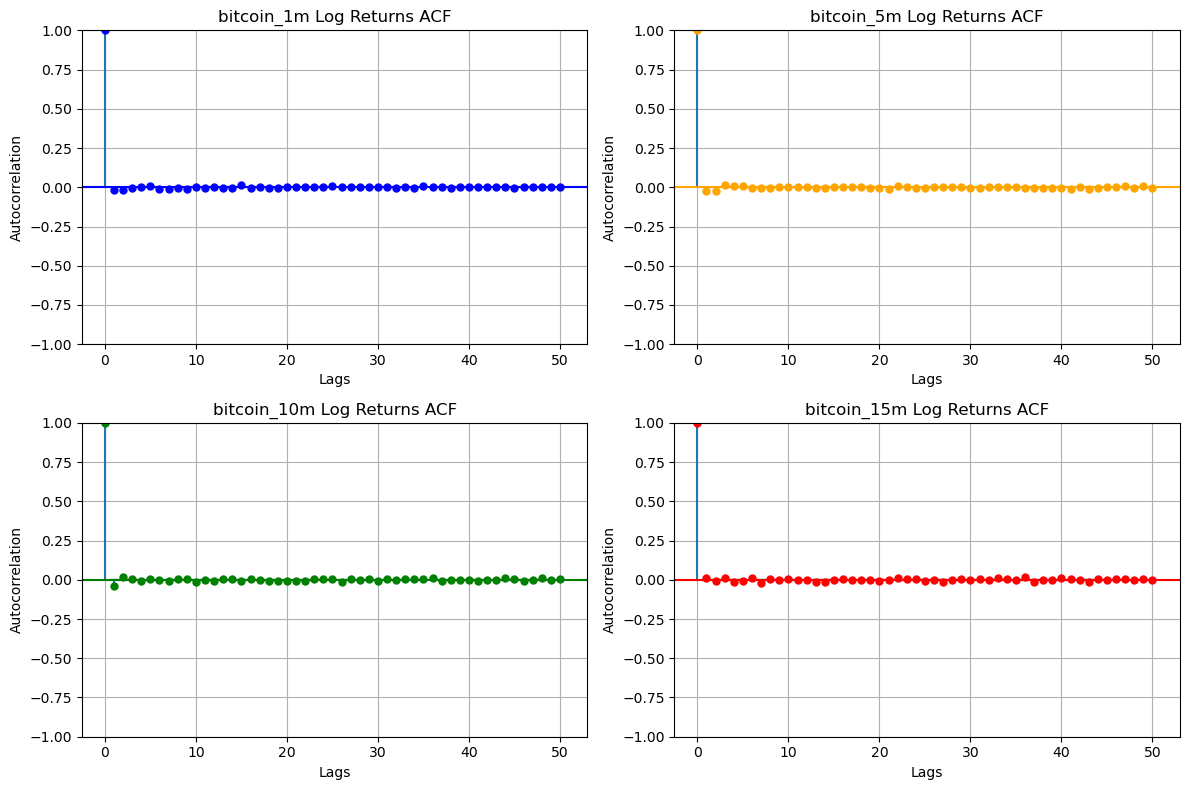

In [99]:
def plot_acf_resampled(resampled_data, start=None, end=None, lags=50):
    """
    Plot ACF (Autocorrelation) for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
        lags (int): Number of lags to display in the ACF plot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for ax, (interval, data) in zip(axes, resampled_data.items()):
        # Filter data if start and end are provided
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        plot_acf(
            data.select("log_returns"), lags=lags, ax=ax, 
            title=f"{interval} Log Returns ACF", 
            color=COLOR_MAP.get(interval, "gray")
        )
        
        ax.grid(True)
        ax.set_xlabel("Lags")
        ax.set_ylabel("Autocorrelation")

    fig.tight_layout()
    plt.show()

start = datetime(2022, 1, 1)
end = datetime(2023, 1, 1)
plot_acf_resampled(resampled_bitcoin, start=start, end=end)

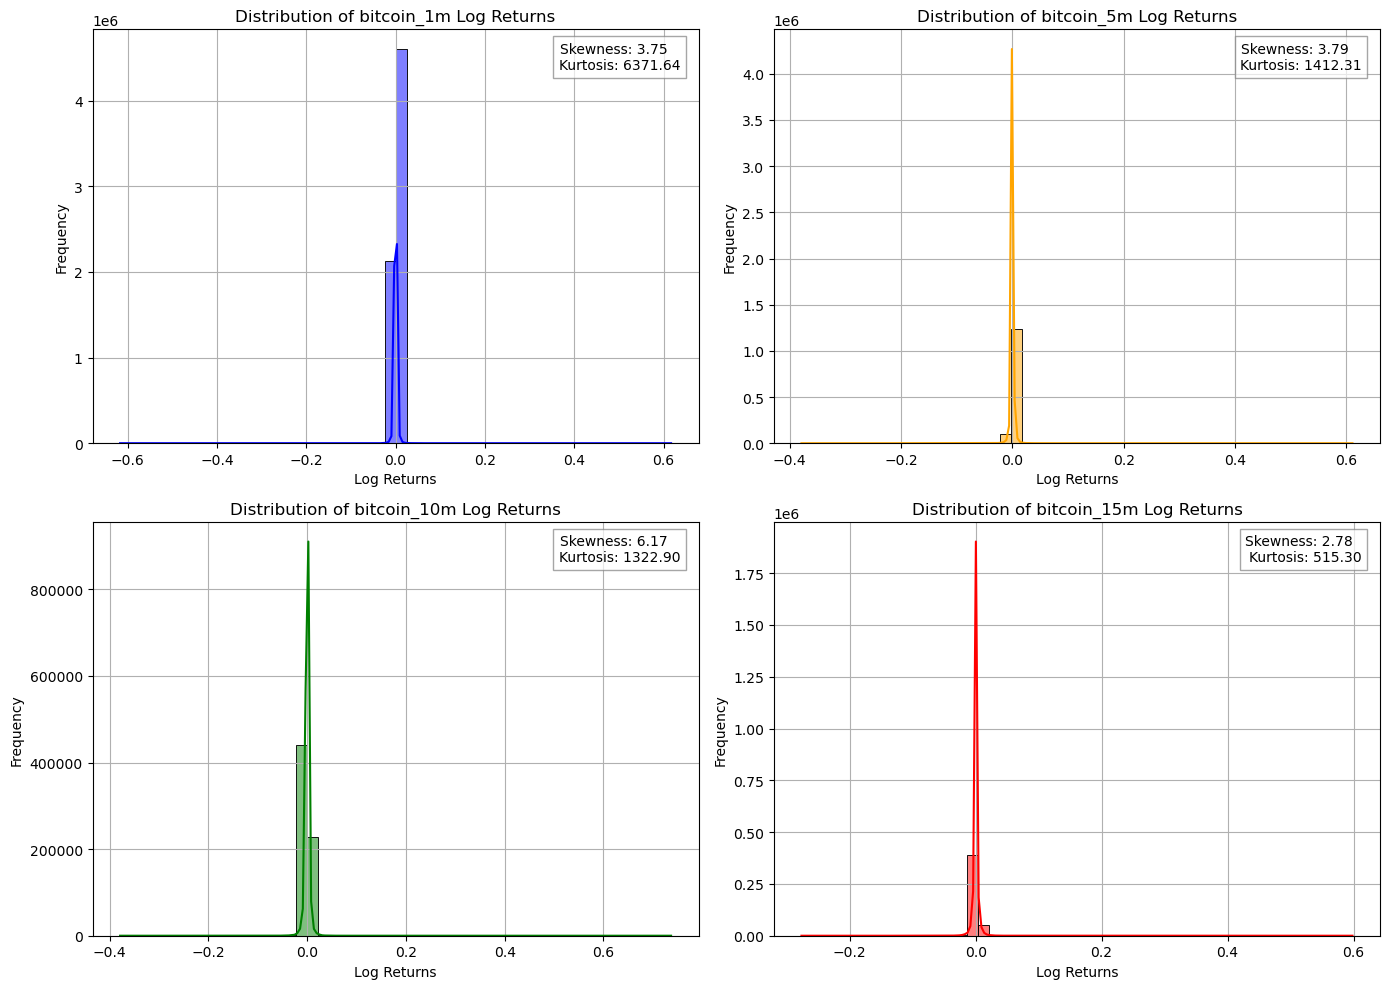

In [103]:
def plot_log_return_histograms(resampled_data, bins=50):
    """
    Plot 2x2 grid of histograms for log returns of different resampled DataFrames,
    with skewness and kurtosis displayed in the top-right corner.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        bins (int): Number of bins for histograms.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (interval, df) in zip(axes, resampled_data.items()):
        log_returns = df.select("log_returns").to_series()

        skewness = skew(log_returns)
        kurt = kurtosis(log_returns)

        sns.histplot(
            log_returns, kde=True, bins=bins, 
            color=COLOR_MAP.get(interval, "gray"), ax=ax
        )
        
        ax.set_title(f"Distribution of {interval} Log Returns")
        ax.set_xlabel("Log Returns")
        ax.set_ylabel("Frequency")
        ax.grid(True)
        
        skew_str = f"Skewness: {skewness:.2f}"
        kurt_str = f"Kurtosis: {kurt:.2f}"

        max_length = max(len(skew_str), len(kurt_str))
        skew_str = skew_str.ljust(max_length)
        kurt_str = kurt_str.ljust(max_length)
        textstr = f"{skew_str}\n{kurt_str}"

        ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    
    fig.tight_layout()
    plt.show()

plot_log_return_histograms(resampled_bitcoin)

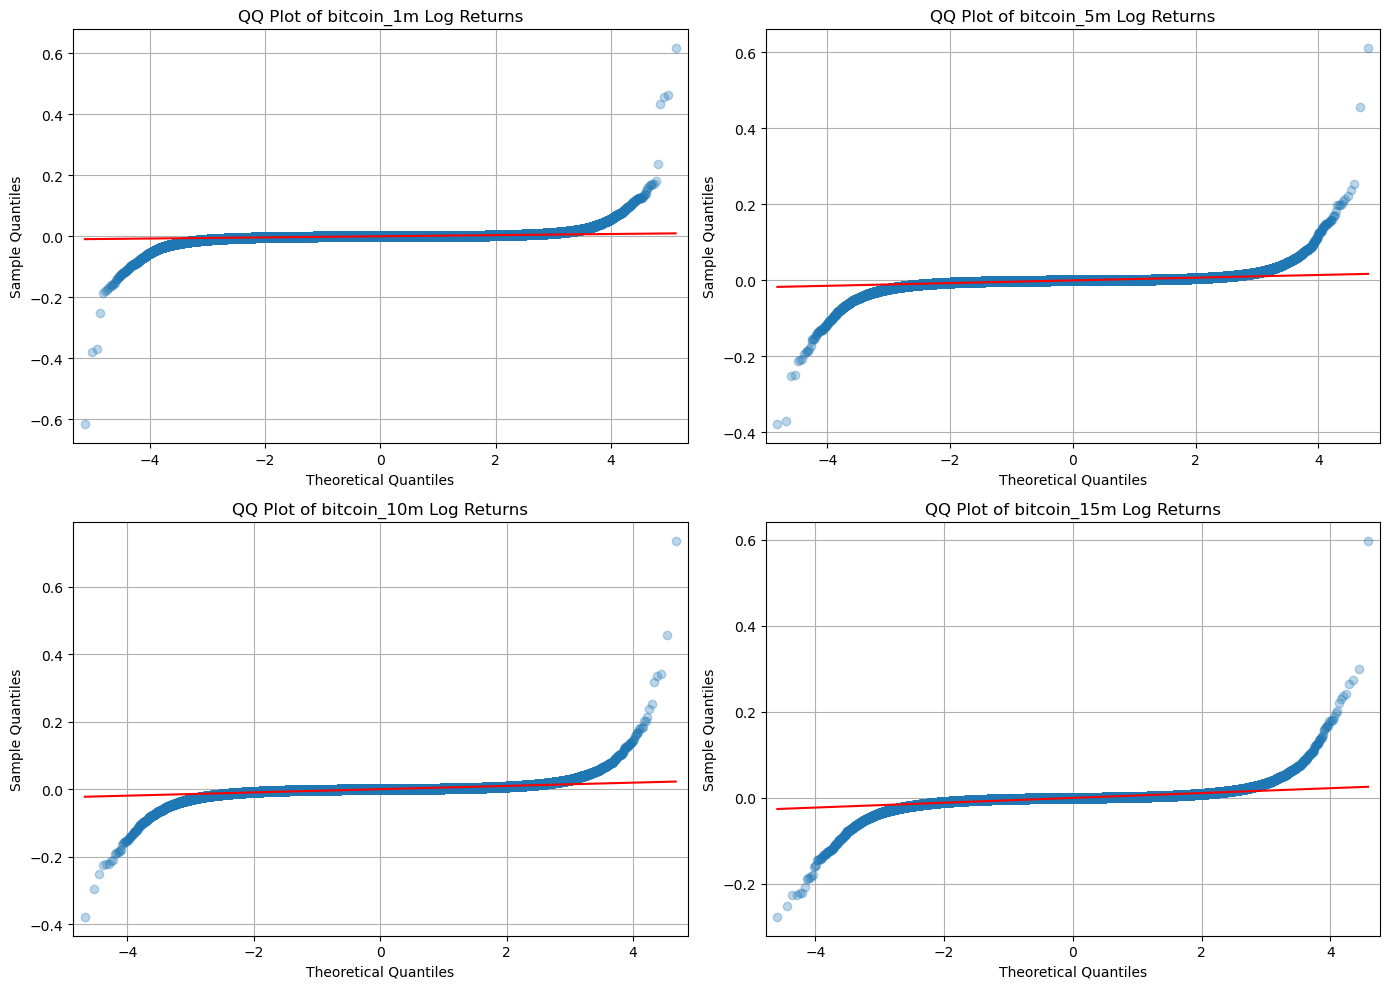

In [107]:
def plot_qq_plots_resampled(resampled_data):
    """
    Plot a 2x2 grid of QQ plots for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (interval, df) in zip(axes, resampled_data.items()):
        qqplot(df.select("log_returns").to_series(), line="s", ax=ax, alpha=0.3)
        ax.set_title(f"QQ Plot of {interval} Log Returns")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Sample Quantiles")
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_qq_plots_resampled(resampled_bitcoin)

It is obvious with the QQ plots that the returns outside of the range (-2%,2%) can be considered as outliers and be removed safely

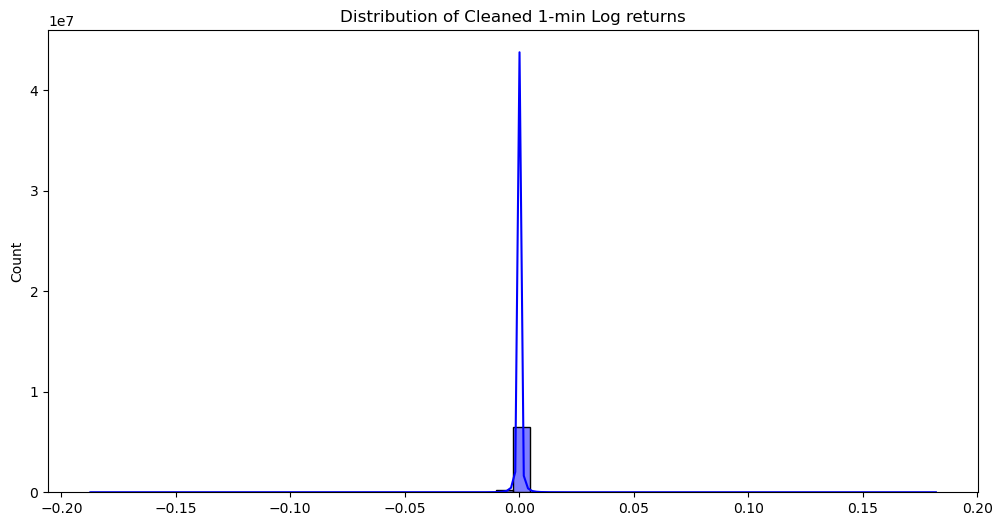

In [11]:
# Define return thresholds based on visual analysis of QQ plot
lower_bound = -0.2  
upper_bound = 0.2

bitcoin = bitcoin.filter(
    (pl.col("log_returns") >= lower_bound) & (pl.col("log_returns") <= upper_bound)
)

plt.figure(figsize=(12, 6))
sns.histplot(
    bitcoin.select("log_returns").to_series(),
    kde=True, bins=50, color="blue"
)
plt.title("Distribution of Cleaned 1-min Log returns")
plt.show()

Despite removing extreme returns the distribution is still widely spread out, so it may be necessary to address the remaining outlier with a more powerful outlier handling technique. For that we are goign to use a **winsorization**.

In [12]:
def winsorize(df, col_name, thresholds):
    """
    Winsorizes a column in a Polars DataFrame for multiple thresholds.

    Args:
        df (pl.DataFrame): The Polars DataFrame containing the column to winsorize.
        col_name (str): The name of the column to winsorize.
        thresholds (list of tuples): List of (lower_percentile, upper_percentile) tuples.

    Returns:
        pl.DataFrame: A new DataFrame with additional winsorized columns.
    """
    for lower_percentile, upper_percentile in thresholds:
        lower_bound = df.select(pl.col(col_name).quantile(lower_percentile))[0, 0]
        upper_bound = df.select(pl.col(col_name).quantile(upper_percentile))[0, 0]
        
        df = df.with_columns(
            pl.col(col_name).clip(lower_bound, upper_bound).alias(
                f"{col_name}_winsorized_{lower_percentile}_{upper_percentile}"
            )
        )
    return df

thresholds = [(0.10, 0.90), (0.05, 0.95), (0.01, 0.99), (0.005, 0.995)]
log_returns_winsorized = winsorize(bitcoin, "log_returns", thresholds)

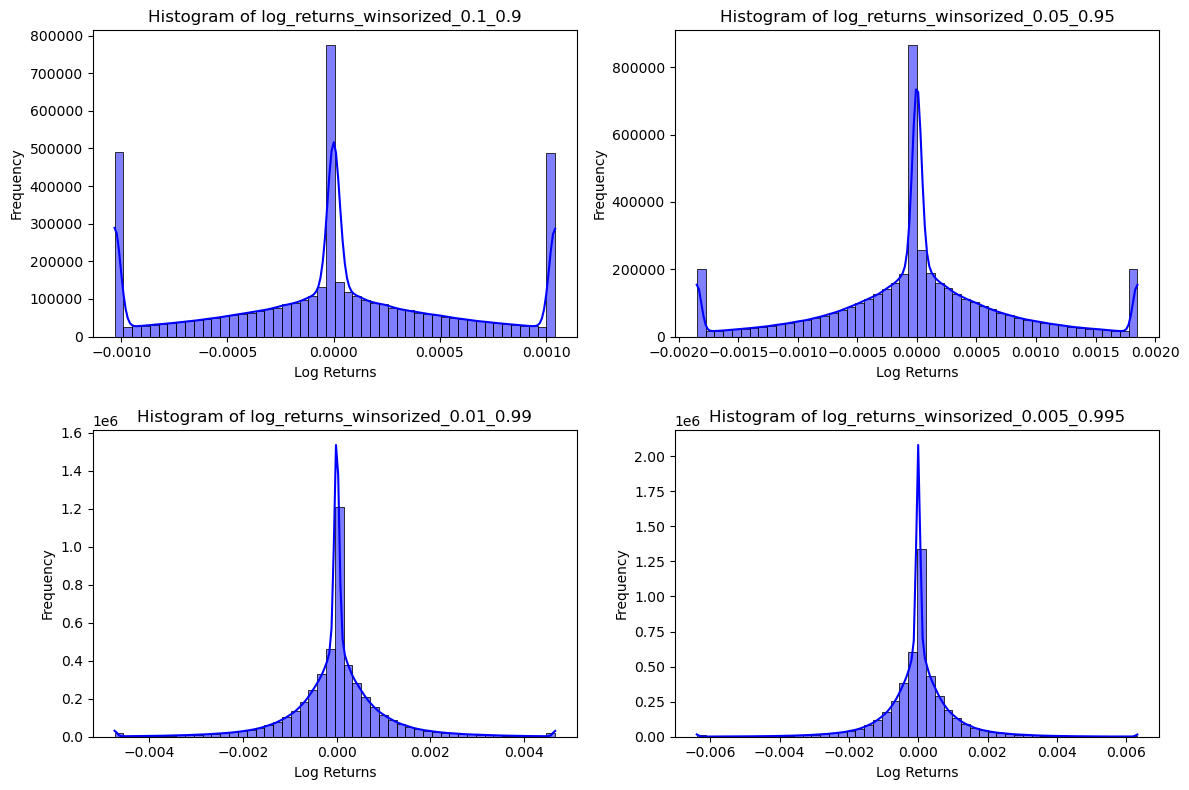

In [13]:
winsorized_columns = [col for col in log_returns_winsorized.columns if "winsorized" in col]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(winsorized_columns):
    sns.histplot(
        log_returns_winsorized.filter(pl.col("Date").dt.date() >= datetime(2016, 1, 1)).select(column).to_series(),
        kde=True, bins=50, ax=axes[i], color="blue"
    )
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Log Returns")
    axes[i].set_ylabel("Frequency")

fig.tight_layout()
plt.show()

The presence of 0 returns create a peaked aorund 0 distribution in all cases, howeevr the **5%-95%** winsorization appears to be the most approrpaiet in this situation.

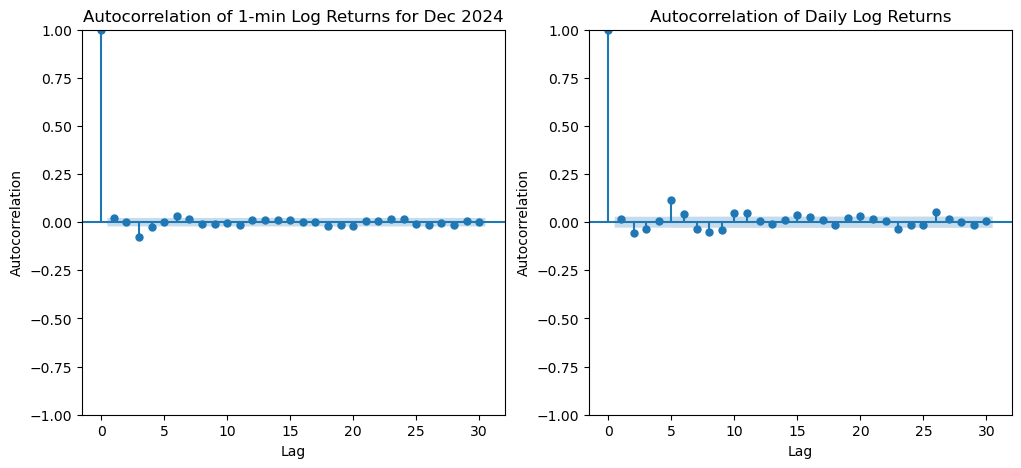

In [14]:
log_returns_dec_2024 = bitcoin.filter(
    pl.col("Date") >= datetime(2024, 12, 1)
).select("log_returns")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(log_returns_dec_2024, lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation of 1-min Log Returns for Dec 2024")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

plot_acf(log_returns_daily.select("log_returns"), lags=30, ax=axes[1])
axes[1].set_title("Autocorrelation of Daily Log Returns")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")

plt.show()

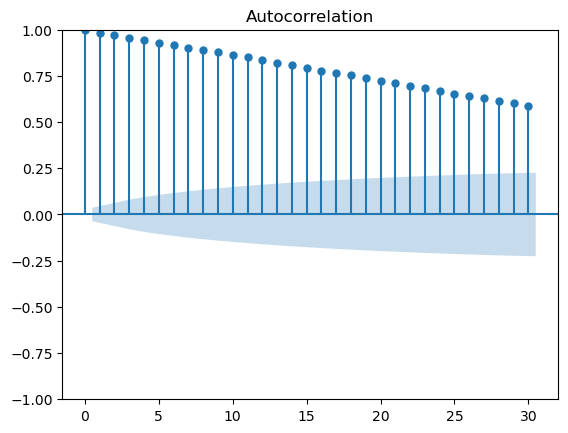

In [15]:
bitcoin = bitcoin.with_columns(
    (pl.col("Close") / pl.col("Close").shift(60)).log().alias("hourly_log_returns")
).filter(
    pl.col("hourly_log_returns").is_not_null()
)
red = bitcoin.filter(
    (pl.col("Date") >= datetime(2024, 1, 1)) & 
    (pl.col("Date") <= datetime(2024, 1, 3)))

plot_acf(red.select("hourly_log_returns"), lags=30);

<Axes: ylabel='Count'>

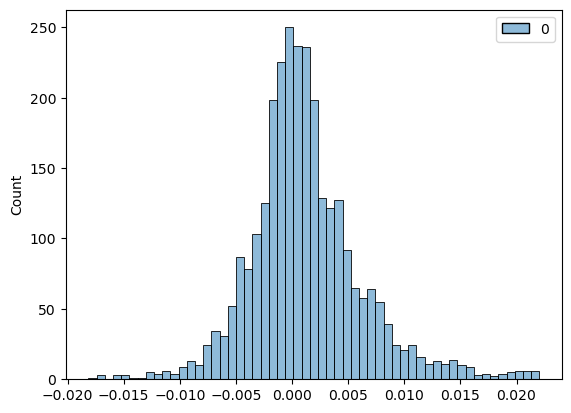

In [ ]:
plt.plot(bitcoin)

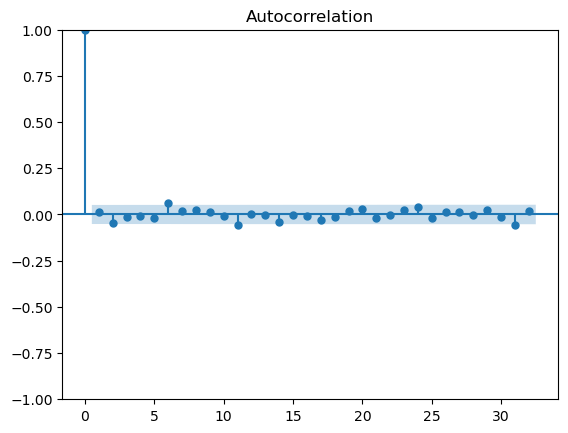

In [22]:
plot_acf(red.to_pandas()["log_returns"]);

In [22]:
bitcoin

Date,Open,High,Low,Close,Volume,log_returns,hourly_log_returns
datetime[μs],f64,f64,f64,f64,f64,f64,f64
2012-01-01 11:02:00,4.58,4.58,4.58,4.58,0.0,0.0,0.0
2012-01-01 11:03:00,4.58,4.58,4.58,4.58,0.0,0.0,0.0
2012-01-01 11:04:00,4.58,4.58,4.58,4.58,0.0,0.0,0.0
2012-01-01 11:05:00,4.58,4.58,4.58,4.58,0.0,0.0,0.0
2012-01-01 11:06:00,4.58,4.58,4.58,4.58,0.0,0.0,0.0
…,…,…,…,…,…,…,…
2024-12-15 23:56:00,104616.0,104616.0,104509.0,104520.0,0.462709,-0.000402,0.011606
2024-12-15 23:57:00,104510.0,104510.0,104257.0,104268.0,27.923539,-0.002414,0.009714
2024-12-15 23:58:00,104258.0,104298.0,104220.0,104298.0,1.929254,0.000288,0.010002


ColumnNotFoundError: Log returns

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["Date", "log_returns"]; PROJECT */2 COLUMNS; SELECTION: None

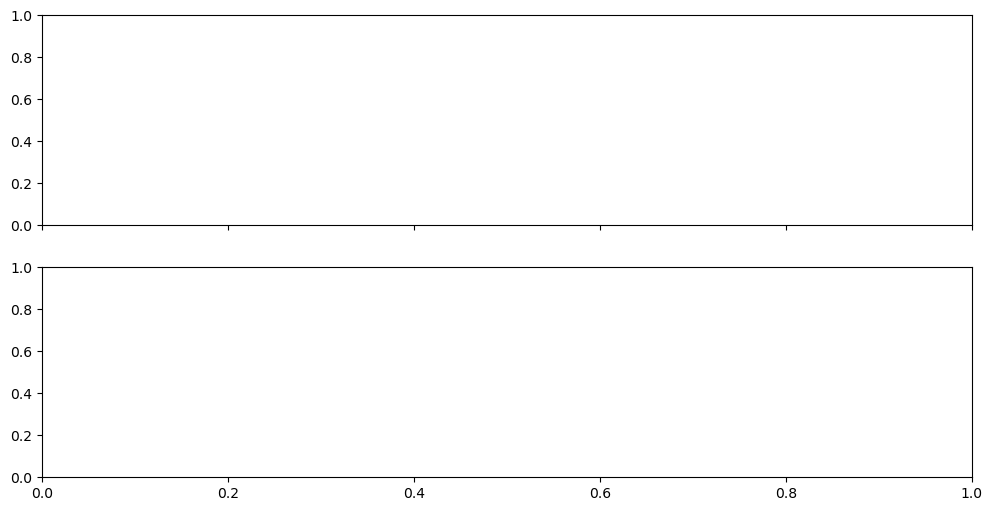

In [52]:
# Train HMM
n_states = 2  # High and low volatility
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
model.fit(log_returns_daily)
posterior_probs = model.predict_proba(log_returns_daily)

posterior_probs = pd.DataFrame(
    posterior_probs, 
    index=log_returns_daily.select("Date").to_series(),
    columns=["State 0","State 1"]
)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(log_returns_daily.select("Date"), log_returns_daily.select("Log returns"), label="Log returns")
axes[0].set_title("Log Returns Over Time")
axes[0].set_ylabel("Log Returns")
axes[0].legend(loc="upper left")

posterior_probs.plot(ax=axes[1])
axes[1].set_title("Posterior Probability of Regimes")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Probability")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
bitcoin_2024 = bitcoin.lazy().with_columns(
    (pl.col("Close") - pl.col("Open")).alias("Daily Change")
).filter(
    pl.col("Date") >= datetime(2022, 1, 1)
).collect()
bitcoin_2024

### **Long Short Term Memory (LSTM)**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.base import BaseEstimator, RegressorMixin

class LSTMModel(nn.Module):
    def __init__(self, n_units=50, input_size=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, n_units, batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, n_units)
        out = out[:, -1, :]    # Take the last timestep's output
        if self.dropout:
            out = self.dropout(out)
        out = self.fc(out)     # (batch, 1)
        return out

class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 learning_rate=0.01,
                 n_units=50,
                 dropout=0.0,
                 loss='mse',
                 epochs=10,
                 batch_size=32,
                 verbose=0,
                 patience=3,
                 seq_len=10,
                 n_workers=0,
                 device=None):
        self.learning_rate = learning_rate
        self.n_units = n_units
        self.dropout = dropout
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.seq_len = seq_len
        self.n_workers = n_workers
        self.is_sequence_model = True

        if device is None:
            if torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)

        self.model_ = None

    def _get_loss_function(self):
        if self.loss == 'mse':
            return nn.MSELoss()
        elif self.loss == 'mae':
            return nn.L1Loss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

    def _create_sequences(self, X, y=None):
        N, _ = X.shape
        if N <= self.seq_len:
            raise ValueError("Number of observations must be greater than seq_len.")

        X_seq = []
        if y is not None:
            y_seq = []

        for i in range(N - self.seq_len):
            X_seq.append(X[i:i+self.seq_len, :])
            if y is not None:
                y_seq.append(y[i+self.seq_len])

        X_seq = np.array(X_seq, dtype=np.float32)
        if y is not None:
            y_seq = np.array(y_seq, dtype=np.float32)
            return X_seq, y_seq
        return X_seq

    def build_model(self, input_size):
        model = LSTMModel(n_units=self.n_units, input_size=input_size, dropout=self.dropout)
        return model.to(self.device)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.values.ravel()  # ensure 1D array

        X_train_seq, y_train_seq = self._create_sequences(X_train, y_train)

        # Create tensors directly on the target device
        X_train_t = torch.tensor(X_train_seq, dtype=torch.float32, device=self.device)
        y_train_t = torch.tensor(y_train_seq, dtype=torch.float32, device=self.device).unsqueeze(-1)

        _, _, input_size = X_train_seq.shape

        if self.model_ is None:
            self.model_ = self.build_model(input_size)

        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.n_workers)

        optimizer = Adam(self.model_.parameters(), lr=self.learning_rate)
        criterion = self._get_loss_function()

        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                preds = self.model_(X_batch)
                loss_val = criterion(preds, y_batch)
                loss_val.backward()
                optimizer.step()
                epoch_loss += loss_val.item() * X_batch.size(0)

            epoch_loss /= len(dataset)
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        return self

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_seq = self._create_sequences(X_test)

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, dtype=torch.float32, device=self.device)
            preds = self.model_(X_test_t)
            return preds.cpu().numpy().ravel()

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # If model parameters changed in a way that requires rebuilding the model:
        self.model_ = None
        return self

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_units': self.n_units,
            'dropout': self.dropout,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'patience': self.patience,
            'seq_len': self.seq_len,
            'device': self.device.type if isinstance(self.device, torch.device) else self.device
        }


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = ['wind_boxcox', 'load']

X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])

X_val = val[X_train.columns]
y_val = val[target]
X_test = test[X_train.columns]
y_test = test[target]

X_val[scaled_features] = scaler.transform(X_val[scaled_features])
X_test[scaled_features] = scaler.transform(X_test[scaled_features])
lstm_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "n_units": [32, 50, 100],
    "dropout": [0.0, 0.1, 0.2]
}

lstm_model = LSTMRegressor(device="cpu", batch_size=64, seq_len=21, learning_rate=0.05)

lstm_best_params = hyperparameter_tuning(
    lstm_model,
    lstm_params,
    X_train,
    y_train,
    X_val,
    y_val,
    imbalances_val,
    val["spread"]
)

results_lstm = evaluate_model(
    lstm_model, lstm_best_params[0], 
    X_train, y_train, X_val, y_val, X_test, y_test, 
    imbalances_test, test["spread"]
)

print(f"Cumulated PnL: {results_lstm['pnl_cumsum'].iloc[-1]:,.2f}€")
results_lstm['pnl_cumsum'].plot(figsize=(12, 6))